In [1]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from math import prod
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed);
torch.manual_seed(manualSeed);

Random Seed:  999


In [2]:
# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div class="alert alert-info">
    <h3>Part 2.3 : OTGAN </h3>
</div>

Implementing the generator and the discriminator class as described in the OTGAN paper

In [3]:
class OTGenerator(nn.Module):
    def __init__(self, lat_dim):
        
        super(OTGenerator, self).__init__()
        self.lin = nn.Linear(lat_dim, 32768)
        self.conv_1 = nn.Conv2d(1024, 1024, 5, 1, 2)
        self.conv_2 = nn.Conv2d(512, 512, 5, 1, 2)
        self.conv_3 = nn.Conv2d(256, 256, 5, 1, 2)
        self.conv_4 = nn.Conv2d(128, 1, 5, 1, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.act = nn.Tanh()
        self.act_2 = nn.Sigmoid()
        
    def forward(self, inp_gen):
        x = self.lin(inp_gen)
        x, y = x.chunk(chunks=2, dim=1)
        x = x * self.act_2(y)
        x = x.view(x.size(0), 1024, 4, 4)
        x = self.upsample(x)
        x = self.conv_1(x)
        x, y = x.chunk(chunks=2, dim=1)
        x = x * self.act_2(y)
        x = self.upsample(x)
        x = self.conv_2(x)
        x, y = x.chunk(chunks=2, dim=1)
        x = x * self.act_2(y)
        x = self.upsample(x)
        x = self.conv_3(x)
        x, y = x.chunk(chunks=2, dim=1)
        x = x * self.act_2(y)
        x = self.act(self.conv_4(x))
        return  x

In [4]:
class OTDiscriminator(nn.Module):
    def __init__(self):
        
        super(OTDiscriminator, self).__init__()
        self.conv_1 = nn.Conv2d(1, 128, 5, 1, 2)
        self.conv_2 = nn.Conv2d(256, 256, 5, 2, 2)
        self.conv_3 = nn.Conv2d(512, 512, 5, 2, 2)
        self.conv_4 = nn.Conv2d(1024, 1024, 5, 2, 2)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = torch.cat((nn.functional.relu(x), nn.functional.relu(-x)), 1)
        x = self.conv_2(x)
        x = torch.cat((nn.functional.relu(x), nn.functional.relu(-x)), 1)
        x = self.conv_3(x)
        x = torch.cat((nn.functional.relu(x), nn.functional.relu(-x)), 1)
        x = self.conv_4(x)
        x = torch.cat((nn.functional.relu(x), nn.functional.relu(-x)), 1)
        x = torch.reshape(x,  (x.size(0), 32768))
        x = nn.functional.normalize(x, p=2, dim=1)
        return x
        

Let's code the OTGAN class

In [5]:
class OTGAN():
    """OTGAN implementation as described in Salimans et al (2018)."""
    def __init__(self, lat_dim , train_ratio, device):

        self.lat_dim  = lat_dim
        self.train_ratio = train_ratio
        self.generator = OTGenerator(lat_dim).to(device)
        self.discriminator = OTDiscriminator().to(device)
        self.device = device


    def compute_cost(self, batch, batch_1):
        return 1 - (batch @ batch_1.t()) / (torch.norm(batch, p=2) * torch.norm(batch_1, p=2))

    
    
    def sinkhorn(self, a, b, C, epsilon=0.5, max_iters=100):
        """Run Sinnkhorn's algorithm"""
        u = torch.ones_like(a, device=self.device)
        with torch.no_grad():
            K = torch.exp(-C/epsilon)
            for i in range(max_iters):
                v = b / torch.matmul(K, u)
                u = a / torch.matmul(K.T, v)

        return torch.matmul(torch.diag(u), torch.matmul(K, torch.diag(v)))

        
    def train(self, dataloader, nbr_epochs, lr_rate, beta):
        
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr_rate, betas=(beta, 0.999))
        opt_g = optim.Adam(self.generator.parameters(), lr=lr_rate, betas=(beta, 0.999))
        fixed_noise = 2 * torch.rand(dataloader.batch_size, self.lat_dim, device=self.device) - 1
        iters = 0
        
        loss_l, img_list = [], []
        
        for epoch in range(nbr_epochs):
            
            for idx, (batch, _) in enumerate(tqdm(dataloader)):
                
                batch, batch_1 = batch.chunk(chunks=2, dim=0)
                batch = batch.to(self.device)
                batch_1 = batch_1.to(self.device)
                
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                
                # Generating fake samples
                fk_smpl_1 = self.generator(2 * torch.rand(batch.size(0), self.lat_dim, device=self.device) - 1)
                fk_smpl_2 = self.generator(2 * torch.rand(batch.size(0), self.lat_dim, device=self.device) - 1)
                
                # prediction on real and fake batches
                pred = self.discriminator(batch)
                pred_2 = self.discriminator(batch_1)
                fk_pred, fk_pred_2 = self.discriminator(fk_smpl_1), self.discriminator(fk_smpl_2)    
                
                
                
                # Computing costs
                cost_pred, cost_pred_fk = self.compute_cost(pred, pred_2), self.compute_cost(pred, fk_pred)
                cost_pred_2_fk, cost_pred_2_fk_2 = self.compute_cost(pred_2, fk_pred), self.compute_cost(pred_2, fk_pred_2)
                cost_pred_fk_2, cost_fk = self.compute_cost(pred, fk_pred_2), self.compute_cost(fk_pred, fk_pred_2)
                
                
                # using the sinkhorn algorithm to compute optimal matchings
                a = (torch.ones(batch.size(0)) / batch.size(0)).to(self.device)
                b = (torch.ones(batch.size(0)) / batch.size(0)).to(self.device)
                
                match_pred, match_pred_fk = self.sinkhorn(a, b, cost_pred), self.sinkhorn(a, b, cost_pred_fk)
                match_pred_fk_2, match_pred_2_fk = self.sinkhorn(a, b, cost_pred_fk_2), self.sinkhorn(a, b, cost_pred_2_fk_2)
                match_pred_2_fk_2, match_fk = self.sinkhorn(a, b, cost_pred_2_fk_2), self.sinkhorn(a, b, cost_fk)

                # Compute loss
                
                loss_pred = torch.sum(match_pred * cost_pred)
                loss_pred_fk = torch.sum(match_pred_fk * cost_pred_fk)
                loss_pred_fk_2 = torch.sum(match_pred_fk_2 * cost_pred_fk_2)
                loss_pred_2_fk = torch.sum(match_pred_2_fk * cost_pred_2_fk)
                loss_pred_2_fk_2 = torch.sum(match_pred_2_fk_2 * cost_pred_2_fk_2)
                loss_fk = torch.sum(match_fk * cost_fk) 
                loss = loss_pred_fk + loss_pred_fk_2 + loss_pred_2_fk + loss_pred_2_fk_2 - 2 * (loss_pred_fk_2 + loss_fk)
                
                loss.backward()

                if idx+1 % self.train_ratio == 0:
                    opt_d.step()
                else :
                    opt_g.step()
                    
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) :
                    with torch.no_grad():
                        fk_img = self.generator(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fk_img, padding=2, normalize=True))
                iters+=1
            
            print("Epoch [{}/{}], loss: {:.4f}".format(epoch+1, nbr_epochs, loss))
            
            # Save Losses for plotting later
            loss_l.append(loss)
        return img_list, loss_l

Hyperparameters for training 

In [6]:
batch_size = 64
image_size = 32
# Number of workers for dataloader
workers = 1
train_loader = torch.utils.data.DataLoader(
 torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])),
  batch_size=batch_size, shuffle=True, num_workers=workers)

# Size of z latent vector (i.e. size of generator input)
lat_dim = 100
# Number of training epochs
nbr_epochs = 20
# Learning rate for optimizers
lr = 3e-4
# Beta hyperparam for Adam optimizers
beta = 0.5
# generator to discriminator training ratio
train_ratio = 3

In [7]:
otgan = OTGAN(lat_dim, train_ratio, device)
img_list_ot, loss_ot = otgan.train(train_loader, nbr_epochs, lr, beta)

  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [1/20], loss: -0.0104


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [2/20], loss: -0.0038


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [3/20], loss: -0.0029


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [4/20], loss: -0.0034


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [5/20], loss: -0.0038


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [6/20], loss: -0.0027


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [7/20], loss: -0.0023


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [8/20], loss: -0.0038


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [9/20], loss: -0.0040


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [10/20], loss: -0.0043


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.0014


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [12/20], loss: -0.0036


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [13/20], loss: -0.0029


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [14/20], loss: -0.0014


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [15/20], loss: -0.0017


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [16/20], loss: -0.0009


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [17/20], loss: -0.0033


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [18/20], loss: -0.0027


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch [19/20], loss: -0.0037


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [14:58<00:00,  1.04it/s]


Epoch [20/20], loss: -0.0022


Let's visualise the images

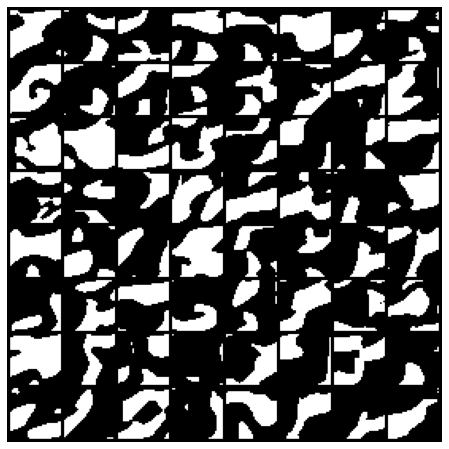

In [8]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_ot]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

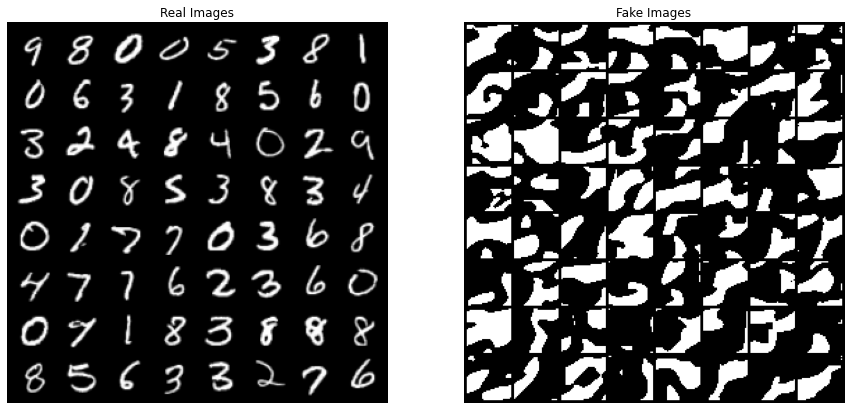

In [10]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list_ot[-1],(1,2,0)))
plt.show()

A not so fancy loss plot

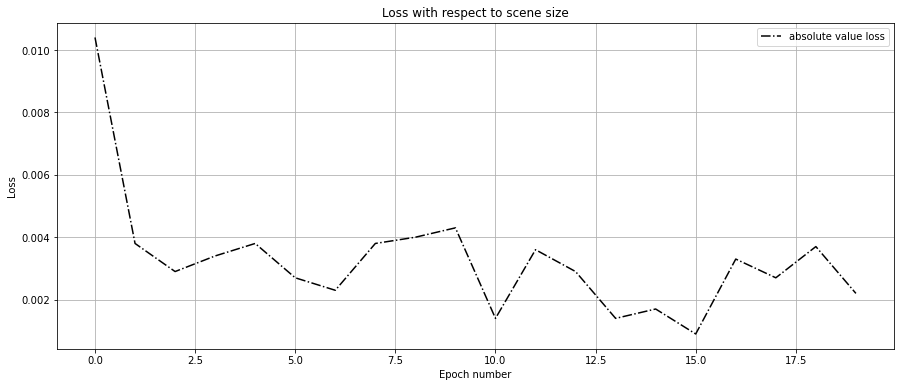

In [18]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(nbr_epochs), np.abs(loss_ot), '-.k', label='absolute value loss') # dashdot black
plt.grid()
plt.legend(loc="upper right")
plt.title('Loss with respect to scene size');
plt.xlabel('Epoch number')
plt.ylabel('Loss');

We can notice that the genrated images do not resembles the one found in the data but this is natural as the batch size was small and this voids one of the pricipals of the OTGAN. Hopefully with more memory one can overcome this issue.